# Загрузка библиотек

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import warnings
warnings.simplefilter('ignore')
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier, PassiveAggressiveClassifier, Perceptron, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import TruncatedSVD
import optuna
from optuna.visualization import *
from imblearn.over_sampling import ADASYN
import spacy
from tqdm import tqdm
import tables

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\levase\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Загрузка данных и работа по их очистке

Подключение к БД и загрузка данных в датафрейм

In [8]:
# Подключение к БД
database_path = r'D:\scripts\diploma\output\database.db'

conn = sqlite3.connect(database_path)
cursor = conn.cursor()
cursor.execute("SELECT category_name_level_0, product_id, description FROM description")
results = cursor.fetchall()
cursor.close()
conn.close()

# Загрузка данных в датафрейм
df = pd.DataFrame(results)
df.columns = ['category', 'product_id', 'description']       

df.head(5)

,category,product_id,description
0,Дом,21617111,"Картины мотивация на стену с ""Лев-мотиватор"" -..."
1,Автотовары,156541071,Колпачки на колесные болты или гайки NEW GALAX...
2,Канцтовары,202471159,Яркие декоративные стикеры в наборе — прекрасн...
3,Сад и дача,165488036,Реле давления PS-07A предназначена для автомат...
4,Автотовары,199034078,"Камера 2,75-17 Alpha, Delta.Модель: Камера 2,7..."


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 370689 entries, 0 to 370688
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   category     370689 non-null  object
 1   product_id   370689 non-null  int64 
 2   description  369127 non-null  object
dtypes: int64(1), object(2)
memory usage: 8.5+ MB


Столбец description имеет пропуски. Посмотрим на них чуть позже.

Пока напишем функцию для просмотра категорий товаров и распределению самих товаров по категориям в нашем датафрейме.


In [10]:
# Функция оценки распределения данных по категориям
def value_counter(series): 
  result = pd.concat([series.value_counts(), series.value_counts(normalize=True).round(4) * 100], axis=1)
  result.columns = ['count', 'percent']
  return result

In [11]:
value_counter(df.category)

,count,percent
category,,
Дом,67210,18.13
Спорт,39521,10.66
Сад и дача,25658,6.92
Книги,24619,6.64
Женщинам,23578,6.36
Электроника,22567,6.09
Детям,20000,5.40
Красота,17800,4.80
Мебель,17632,4.76


Видно, что данные по категориям распределены не равномерно, что в дальнейшем повлияет на выбор методов при обучении модели.

In [12]:
df.description.sort_values().head(50)

206737                                                     
166873                                                     
113390                                                     
3765           Вал вторичный редуктора, для мотоблоков к...
268154     Свадьба это очень радостное и волнительное со...
995       ! Аккумулятор и зарядное устройство в комплект...
38974     ! Аккумулятор и зарядное устройство в комплект...
1400      ! Аккумулятор и зарядное устройство в комплект...
1525      ! Аккумулятор и зарядное устройство в комплект...
362247    ! Аккумулятор и зарядное устройство в комплект...
361853    ! Аккумулятор и зарядное устройство в комплект...
124963    ! Аккумулятор и зарядное устройство в комплект...
362137    ! Аккумулятор и зарядное устройство в комплект...
39458     ! Аккумулятора и зарядного устройства в компле...
1298      ! Аккумулятора и зарядного устройства в компле...
34550     ! Без соединительных головок в комплекте. Рука...
34051     ! Без соединительных головок в

Из вывода выше видим, что в 'description' присутствуют пустые строки, множественные пробелы, а также английские буквы.
Поработаем над этим.

In [13]:
def return_none(text):
    if text is not None and len(text) == 0:
        return None
    return text

In [14]:
# Убираем все латинские буквы
df['description_rus'] = df['description'].str.replace(r'[A-Za-z]', '', regex=True)

In [15]:
# Заменяем множественные пробелы на один пробел
df['description_rus'] = df['description_rus'].str.replace(r'\s+', ' ', regex=True).str.strip()

In [16]:
# Обрабатываем пустые строки
df['description_rus'] = df['description_rus'].apply(return_none)

Посмотрим на распределение пропусков по категориям.

In [17]:
100 * (df[['category', 'product_id']][df['description_rus'].isnull() == True]\
       .groupby(by='category').count().rename(columns={'product_id': 'percent'})/df.shape[0]).sort_values(by='percent', ascending=False).round(5)

,percent
category,
Дом,0.069
Автотовары,0.064
Спорт,0.039
Детям,0.028
Электроника,0.027
Сад и дача,0.024
Книги,0.023
Для ремонта,0.023
Женщинам,0.020


Количество пропусков по категориям незначительно. Уберём их.

In [18]:
df.dropna(inplace=True)

Для дальнейшей работы нам не понадобятся столбцы product_id и description, уберём их.

In [19]:
df.drop(columns='product_id', inplace=True)
df.drop(columns='description', inplace=True)
df.reset_index(drop=True, inplace=True)

Посмотрим на количество дубликатов

In [20]:
100 * (df[df.duplicated()].count() / df.shape[0]).round(4)

category           33.1
description_rus    33.1
dtype: float64

Каждая третья запись в датасете является дубликатом. Посморим на распределение дубликатов по категориям.

In [21]:
value_counter(df[df.duplicated()].category)

,count,percent
category,,
Дом,22250,18.21
Спорт,16894,13.83
Женщинам,11867,9.71
Мебель,8204,6.71
Красота,7671,6.28
Сад и дача,7410,6.06
Детям,7285,5.96
Электроника,6418,5.25
Книги,5607,4.59


В среднем, распределение дубликатов по категориям коррелирует с распределением данных по категориям. 

Посмотрим на распределение данных дедуплицированного датафрейма.

In [22]:
df_wo_duplicates = df.drop_duplicates().reset_index(drop=True)
value_counter(df_wo_duplicates.category)

,count,percent
category,,
Дом,44704,18.10
Спорт,22484,9.11
Книги,18926,7.66
Сад и дача,18160,7.35
Электроника,16048,6.50
Автотовары,13787,5.58
Для ремонта,12751,5.16
Детям,12613,5.11
Женщинам,11636,4.71


In [23]:
df_wo_duplicates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246926 entries, 0 to 246925
Data columns (total 2 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   category         246926 non-null  object
 1   description_rus  246926 non-null  object
dtypes: object(2)
memory usage: 3.8+ MB


Пропуски данных отсутствуют. Посмотим, сможем ли мы еще найти что "зачистить"?

In [24]:
df_wo_duplicates.description_rus.sort_values()

61744     ! - паста для создания силиконовых форм, состо...
243213    ! - это быстрая весёлая игра, развивающая зрит...
55699     ! - это быстрая весёлая игра, развивающая зрит...
153974    ! А как насчет бриллиантов на губах? Блеск для...
1154      ! Аккумулятор и зарядное устройство в комплект...
                                ...                        
170873    【Плавный и легкий】 поставляется с 12 4- 100 (д...
18200     【Портативный угольный гриль 】 Портативный угол...
98287     【Совместим с батареями 】 Совместим с аккумулят...
196589                          太阳捕手20多面光之立方体合色棱镜阳光扑手创意礼物水晶
4595      防跌落智能扫地机，遇到悬空，会触动底部感应装置，迅速规避防止跌落；适用于多种地板材质（地毯、...
Name: description_rus, Length: 246926, dtype: object

Обратим внимание, что в 'description_rus' присутствуют иероглифы. Уберем их.

In [25]:
# Уберем все иероглифы из диапазона 4E00–9FFF
# https://symbl.cc/en/unicode/blocks/cjk-unified-ideographs/
df_wo_duplicates['description_rus'] = df_wo_duplicates['description_rus'].str.replace(r'[\u4e00-\u9fff]+', '', regex=True)

In [26]:
df_wo_duplicates.description_rus.sort_values()

61744     ! - паста для создания силиконовых форм, состо...
243213    ! - это быстрая весёлая игра, развивающая зрит...
55699     ! - это быстрая весёлая игра, развивающая зрит...
153974    ! А как насчет бриллиантов на губах? Блеск для...
1154      ! Аккумулятор и зарядное устройство в комплект...
                                ...                        
171082    【Отличная производительность】Благодаря процесс...
170873    【Плавный и легкий】 поставляется с 12 4- 100 (д...
18200     【Портативный угольный гриль 】 Портативный угол...
98287     【Совместим с батареями 】 Совместим с аккумулят...
4595                                              ，，，；（、、）。
Name: description_rus, Length: 246926, dtype: object

В выводе видно, что имеются строки без букв. Посмотрим на их количество.

In [27]:
df_wo_duplicates[~df_wo_duplicates['description_rus'].str.contains('[а-яёА-ЯЁ]')]

,category,description_rus
828,Автотовары,15
1167,Автотовары,14
1854,Автотовары,1 /////
2280,Автотовары,3 [81] 2003-2013 3 [8] 2004-2013 3 (8) 2012-20...
3170,Автотовары,"#,#,#,#,#,1 13/15/18 82"
...,...,...
213292,Электроника,"105 , 200 , 210 , 300 , 310 , 85 , 95 , 10, 20..."
213436,Электроника,"1 , 15, 16, 3 , 40 , 50 , 60 ."
218547,Дом,2
224654,Продукты,", ' . , , , & . ' : / '"


Уберем из датафрейма строки, в которых не содержатся буквы.

In [28]:
df_wo_duplicates = df_wo_duplicates[df_wo_duplicates['description_rus'].str.contains('[а-яёА-ЯЁ]')]
df_wo_duplicates.reset_index(drop=True, inplace=True)

In [29]:
df_wo_duplicates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246808 entries, 0 to 246807
Data columns (total 2 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   category         246808 non-null  object
 1   description_rus  246808 non-null  object
dtypes: object(2)
memory usage: 3.8+ MB


Очистим наши данные от стоп-слов.

In [30]:
stop = stopwords.words(['russian'])

In [31]:
# Функция очистки датафрейма от стоп-слов
def string_splitter(series):
  return series.str.lower().str.split().apply(lambda x: [word for word in x if word not in stop]).apply(lambda x: ' '.join(x))

In [32]:
df_wo_duplicates['desc_wo_stopwords'] = string_splitter(df_wo_duplicates.description_rus)

In [33]:
df_wo_duplicates['desc_wo_stopwords']

0         картины мотивация стену "лев-мотиватор" - совр...
1         колпачки колесные болты гайки , упакованы набо...
2         яркие декоративные стикеры наборе — прекрасный...
3         реле давления -07 предназначена автоматизации ...
4         камера 2,75-17 , .модель: камера 2,75-17 , 2. ...
                                ...                        
246803    набор 5 конвертов бумажных пастельных оттенков...
246804    набор плотных белых конвертов формата а3 докум...
246805    конверт почтовый формата с5 предназначен рассы...
246806    ожидание подарка - приятнее самого подарка! сл...
246807    предлагаем качественные надежные курьерские по...
Name: desc_wo_stopwords, Length: 246808, dtype: object

Определим количество символов, которые содержатся в описаниях товаров (description).

Потребуется в дальнейшем для обучения модели на символьных признаках.

In [34]:
charset = df_wo_duplicates['desc_wo_stopwords'].apply(Counter).apply(pd.Series)
charset = charset.sort_index(axis=1, ascending=False)

In [35]:
display(charset.head(), charset.columns)

,�,～,＞,；,：,－,，,）,（,！,...,),(,',&,%,$,#,"""",!,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,123.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,137.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,158.0


Index(['�', '～', '＞', '；', '：', '－', '，', '）', '（', '！',
       ...
       ')', '(', ''', '&', '%', '$', '#', '"', '!', ' '],
      dtype='object', length=329)

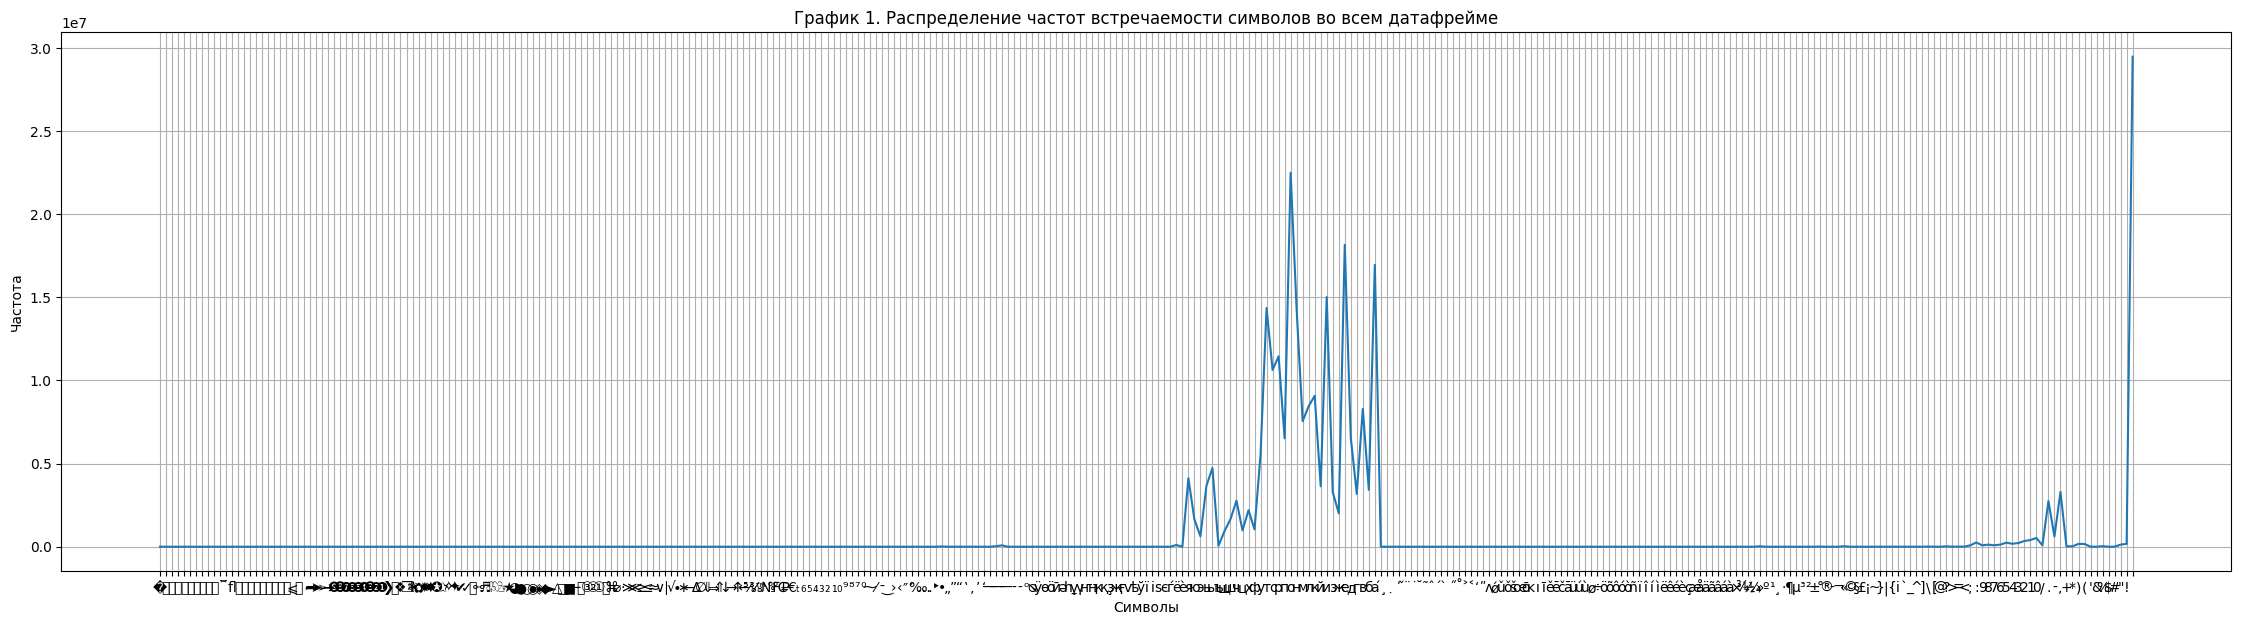

In [36]:
plt.figure(figsize=[28, 7])
plt.plot(charset.sum())
plt.title('График 1. Распределение частот встречаемости символов во всем датафрейме')
plt.ylabel('Частота')
plt.xlabel('Символы')
plt.grid()
plt.show()

Из графика видно, что наиболее часто появляющиеся символы это буквы русского алфавита, цифры, некоторые спец символы, а также пробел.

Также видим большое количество символов, которые также появляются в нашем датафрейме, но крайне редко (в сопоставлении с вышеуказанными символами).

Объединяем полученные признаки с признаком текстового описания.

Далее посмотрим как распределены частоты встречаемости и пропусков символов для каждой категории товаров.


In [37]:
dfchar = pd.concat([df_wo_duplicates, charset], axis=1)
dfchar.reset_index(drop=True, inplace=True)
dfchar.drop('description_rus', axis=1, inplace=True)
dfchar.head()

,category,desc_wo_stopwords,�,～,＞,；,：,－,，,）,...,),(,',&,%,$,#,"""",!,
0,Дом,"картины мотивация стену ""лев-мотиватор"" - совр...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,123.0
1,Автотовары,"колпачки колесные болты гайки , упакованы набо...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.0
2,Канцтовары,яркие декоративные стикеры наборе — прекрасный...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,137.0
3,Сад и дача,реле давления -07 предназначена автоматизации ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.0
4,Автотовары,"камера 2,75-17 , .модель: камера 2,75-17 , 2. ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,158.0


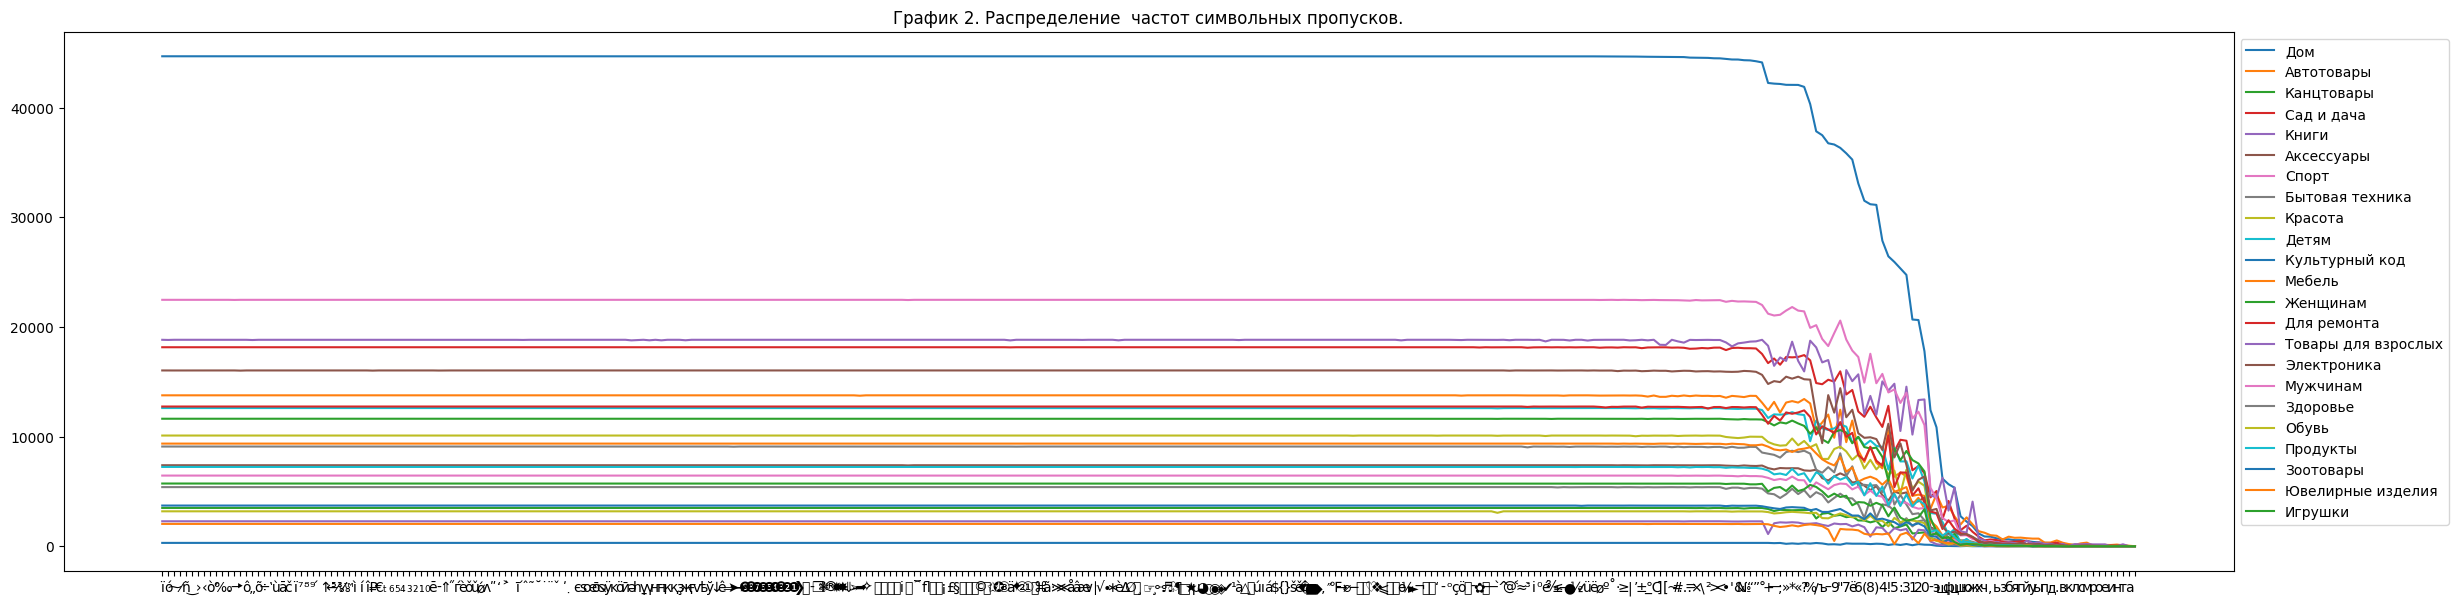

In [38]:
plt.figure(figsize=[28, 7])

for category in dfchar.category.unique():
  sns.lineplot(dfchar[dfchar.category == category].iloc[:,2:].isna().sum().sort_values(ascending=False), label=category)

plt.title('График 2. Распределение  частот символьных пропусков.')
plt.legend(bbox_to_anchor=(1, 1), loc=2) 
plt.show()

Из графика видно, что больше всего пропусков в категории товаров "Дом".

Частота пропусков снижается по всем категориям после символа "+".

In [39]:
# char_by_category=(dfchar.iloc[:,2:].groupby(dfchar.category).
#                      sum()/dfchar.iloc[:,2:].
#                      shape[0])
# char_by_category

In [40]:
# Функция подсчета пропусков символов
def nan_counter(dataframe, sorting='Values'):
  if sorting=="Values":
    return dataframe.isna().sum().sort_values(ascending=False)
  else:
    return dataframe.isna().sum().sort_index(ascending=False)

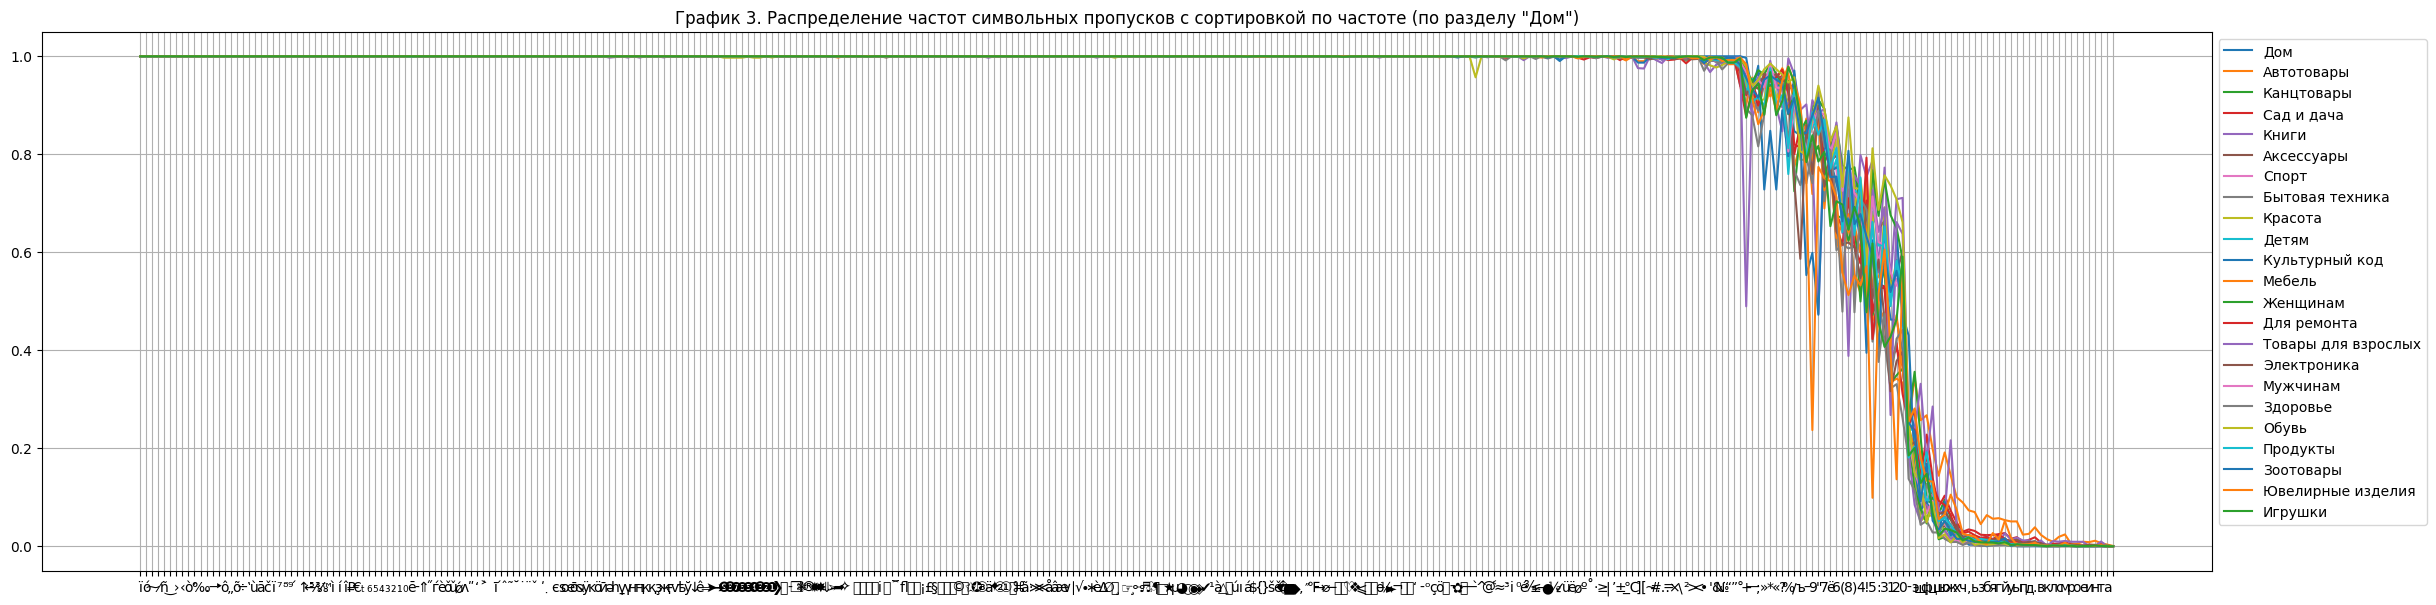

In [41]:
plt.figure(figsize=[28, 7])

for category in dfchar.category.unique():
  nan_by_category=nan_counter(dfchar[dfchar.category == category].iloc[:, 2:])
  sns.lineplot(nan_by_category/(dfchar[dfchar.category == category].shape[0]), label=category)

plt.title('График 3. Распределение частот символьных пропусков с сортировкой по частоте (по разделу "Дом")')
plt.legend(bbox_to_anchor=(1, 1), loc=2) 
plt.grid()
plt.show()

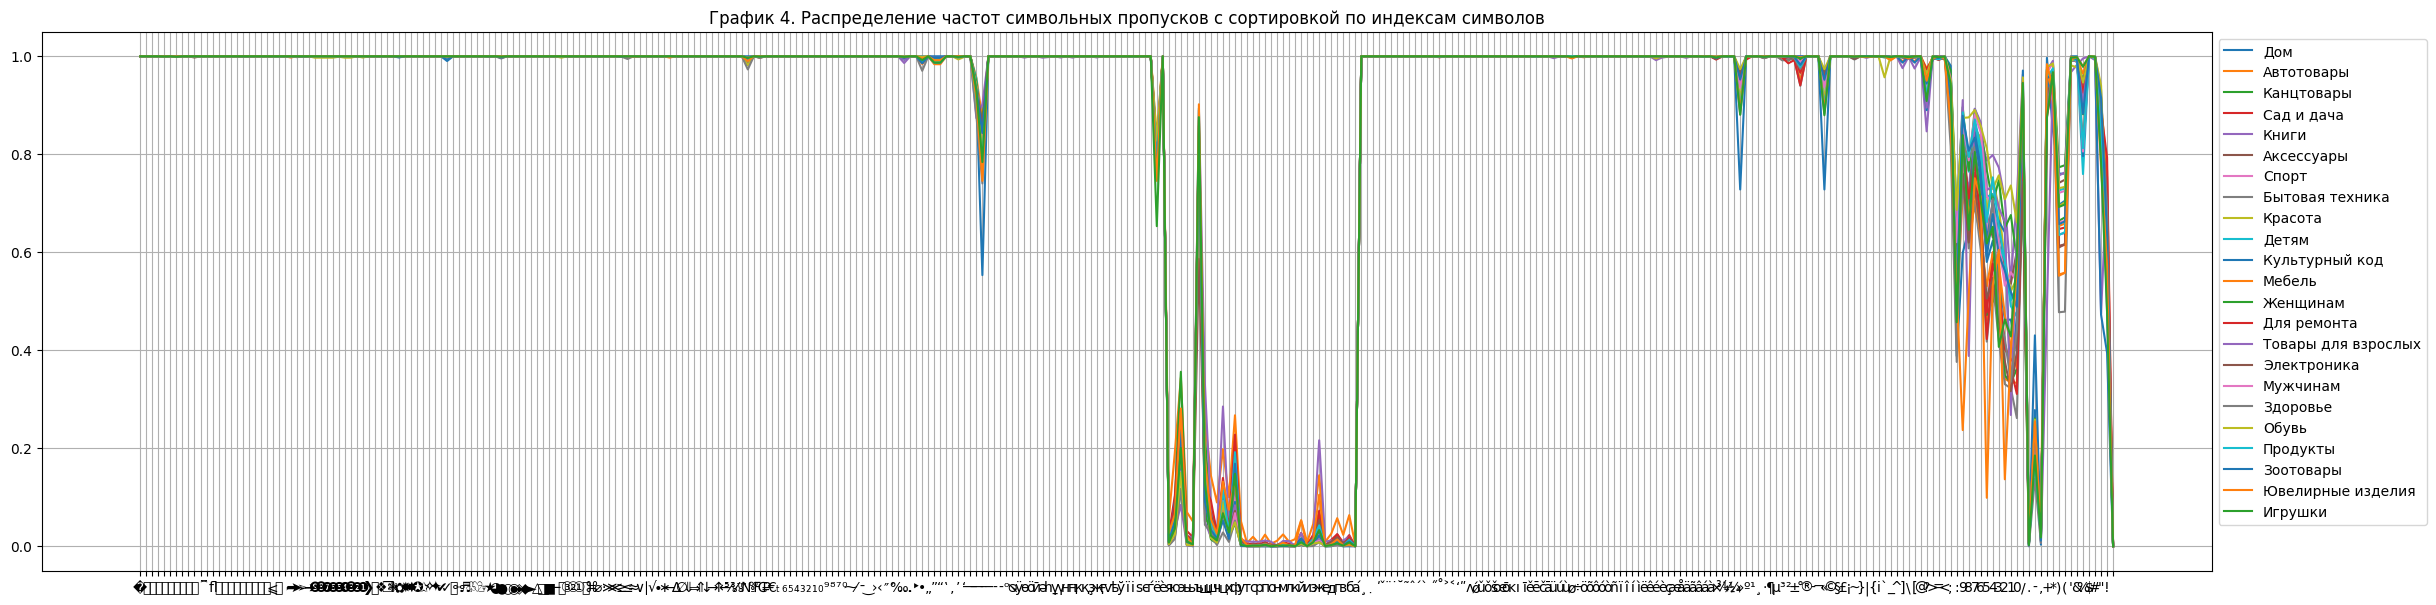

In [42]:
plt.figure(figsize=[28, 7])

for category in dfchar.category.unique():
  nan_by_category=nan_counter(dfchar[dfchar.category == category].iloc[:, 2:], 'index')
  sns.lineplot(nan_by_category/(dfchar[dfchar.category == category].shape[0]), label=category)

plt.title('График 4. Распределение частот символьных пропусков с сортировкой по индексам символов')
plt.legend(bbox_to_anchor=(1, 1), loc=2)
plt.grid() 
plt.show()

Из графика явно выделяются две области с относительно нижким пропуском символов по всем категориям товаров: буквы русского алфавита, цифры и некоторые спец символы.


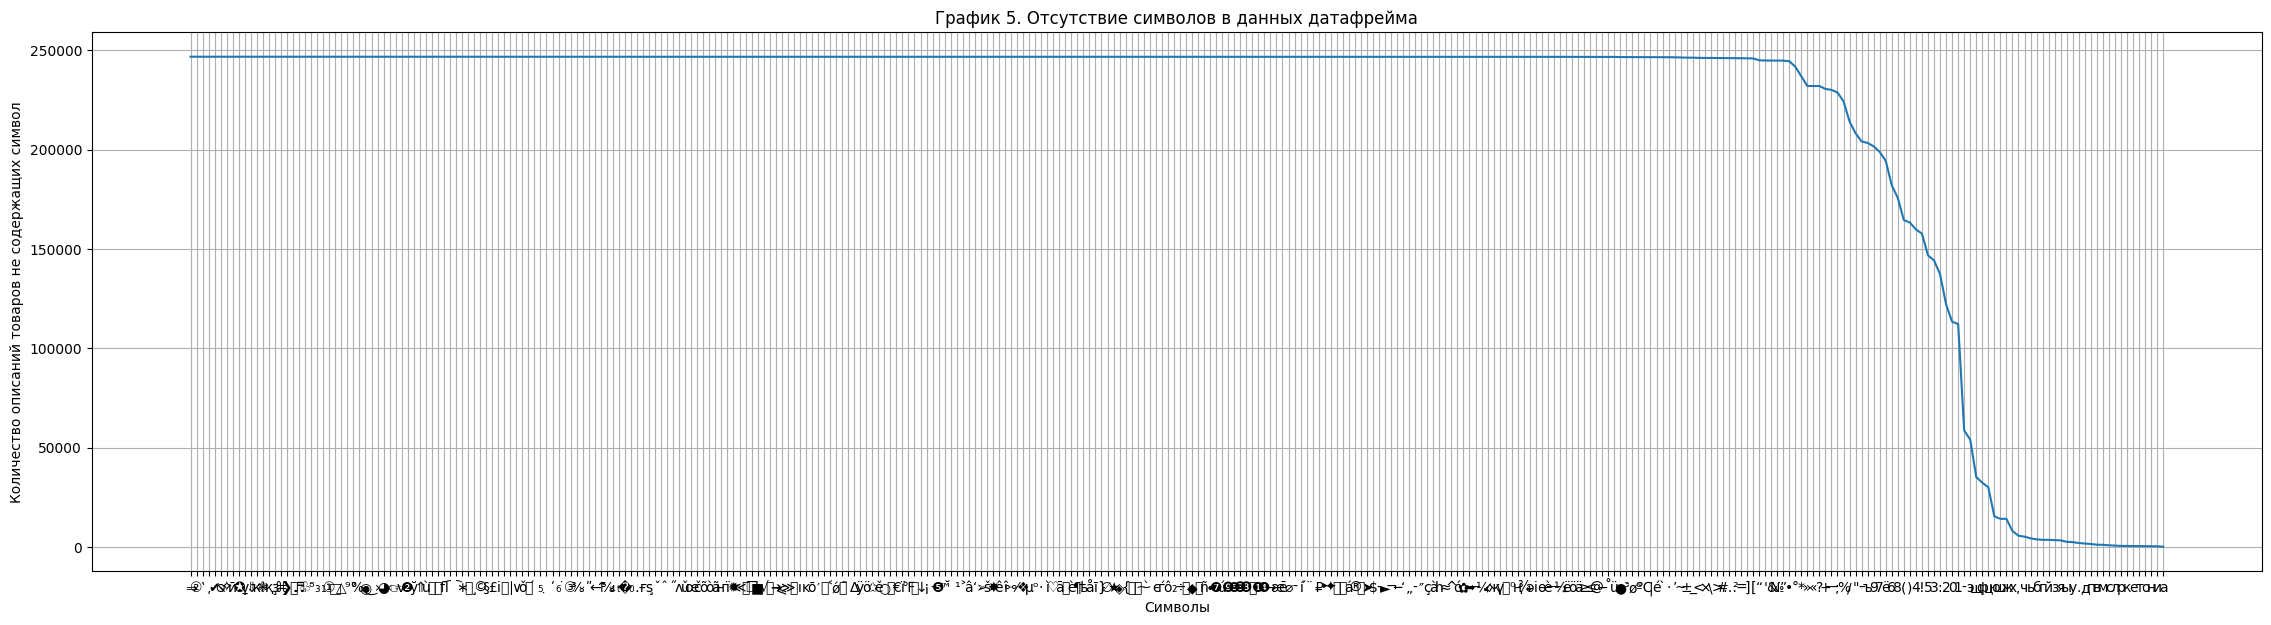

In [43]:
plt.figure(figsize=[28, 7])
sns.lineplot(nan_counter(dfchar.iloc[:, 2:-1]))
plt.title('График 5. Отсутствие символов в данных датафрейма')
plt.xlabel('Символы')
plt.ylabel('Количество описаний товаров не содержащих символ')
plt.grid()
plt.show()

Из графика видно три области встречаемости символов:

1. Область редкой встречаемости символов.
От левой части графика до знака "+".
2. Область резкого роста встречаемости символов.
От знака "+" до буквы "р". Этот диапазон наиболее благоприятен для включения в символьные признаки для обучения модели.
3. Область стагнирования встречаемости символов.
После буквы "р" рост встречаемости символов останавливается, что говорит о часто встречаемости символов во всем датафрейме.

Оставим в качестве символьных признаков все признаки из области резкого роста встречаемости символов.

In [44]:

charslist = nan_counter(dfchar.query('category=="Дом"').iloc[:, 2:], ).index.to_list()
dfchar = pd.concat([dfchar.iloc[:, :2], dfchar[charslist[charslist.index('+'): charslist.index('р') + 1]]], axis=1)
dfchar

,category,desc_wo_stopwords,+,—,;,»,*,«,?,%,...,ы,п,д,.,в,к,л,с,м,р
0,Дом,"картины мотивация стену ""лев-мотиватор"" - совр...",NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,22.0,28.0,35.0,9.0,19.0,35.0,17.0,34.0,34.0,65.0
1,Автотовары,"колпачки колесные болты гайки , упакованы набо...",1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.0,10.0,6.0,5.0,16.0,22.0,19.0,17.0,10.0,9.0
2,Канцтовары,яркие декоративные стикеры наборе — прекрасный...,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,21.0,28.0,31.0,12.0,26.0,69.0,49.0,45.0,31.0,41.0
3,Сад и дача,реле давления -07 предназначена автоматизации ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.0,9.0,8.0,3.0,14.0,9.0,12.0,17.0,13.0,13.0
4,Автотовары,"камера 2,75-17 , .модель: камера 2,75-17 , 2. ...",NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,...,20.0,41.0,30.0,14.0,41.0,44.0,41.0,56.0,44.0,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246803,Канцтовары,набор 5 конвертов бумажных пастельных оттенков...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0,3.0,5.0,2.0,4.0,7.0,2.0,3.0,6.0,7.0
246804,Канцтовары,набор плотных белых конвертов формата а3 докум...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,36.0,44.0,33.0,15.0,58.0,47.0,40.0,42.0,49.0,65.0
246805,Канцтовары,конверт почтовый формата с5 предназначен рассы...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16.0,17.0,7.0,13.0,29.0,35.0,14.0,16.0,20.0,34.0
246806,Канцтовары,ожидание подарка - приятнее самого подарка! сл...,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,...,51.0,70.0,78.0,17.0,80.0,80.0,56.0,59.0,55.0,105.0


Для проверки всё ли мы правильно удалили, повторно строим график пропусков

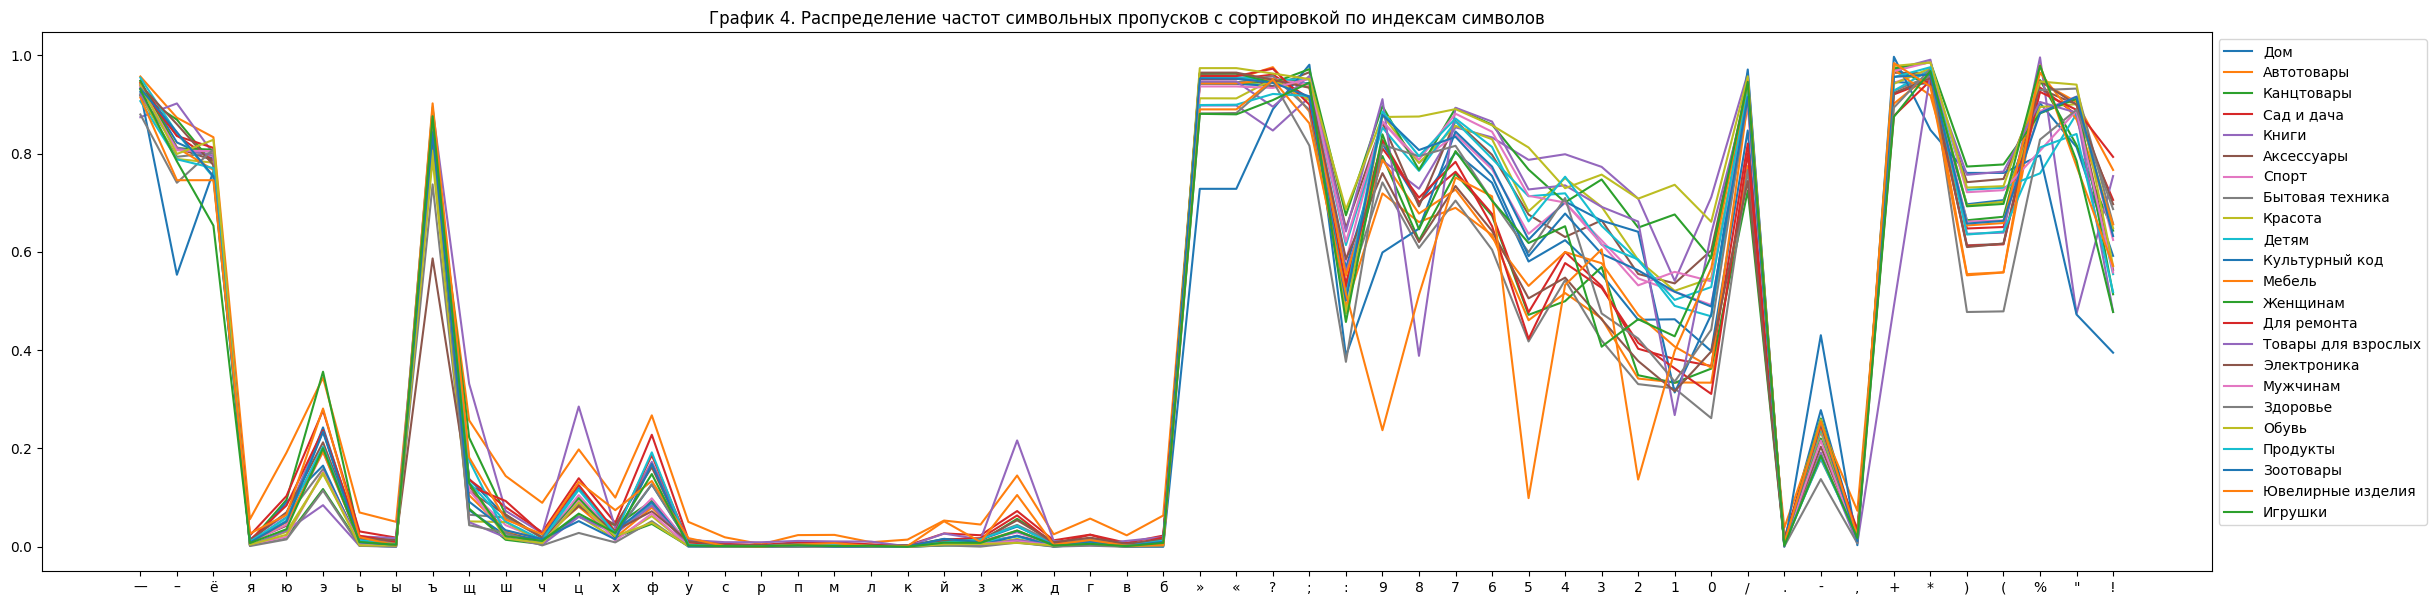

In [45]:
plt.figure(figsize=[28, 7])

for category in dfchar.category.unique():
  nansbycategory=nan_counter(dfchar[dfchar.category==category].iloc[:, 2:], "1")
  sns.lineplot(nansbycategory/(dfchar[dfchar.category==category].shape[0]), label=category)
  
plt.legend(bbox_to_anchor=(1, 1), loc=2) 
plt.title('График 4. Распределение частот символьных пропусков с сортировкой по индексам символов')
plt.show()

На графике видно, что большинство символов имеет аналогичное распределение частот пропусков для всех категорий товаров. 

Некоторые символы (особенно редкие буквы и специальные символы) часто пропускаются или вообще не используются.

Добавим в наш датафрейм числовое обозначение каждой категории.

In [46]:
dfchar['category_label'] = dfchar.category.map(dict(zip(dfchar.category.unique(), range(len(dfchar.category.unique())))))

Для наглядности, отобразим полученное соответствие категорий с их цифровым обозначением.

In [47]:
pd.DataFrame(dict(zip(dfchar.category.unique(), range(len(dfchar.category.unique())))), index=["category_number"]).T 

,category_number
Дом,0
Автотовары,1
Канцтовары,2
Сад и дача,3
Книги,4
Аксессуары,5
Спорт,6
Бытовая техника,7
Красота,8
Детям,9


Поскольку большинство методов чувствительно к пропскам в данных, мы заменяем пропуски нулевыми значениями, поскольку пропуски в нашем случае это именно нулевые количества символов в документах, а не отсутствие данных о значениях.

In [48]:
dfchar.fillna(0, inplace=True)

# Построение базовой модели на символьных признаках

Разделим датафрейм на тренировочную, валидационную и тестовую выборки.

* помним, что растределение товаров по категориям не равномерное. Посмотрим как справится модель. Далее обработаем этот момент.

In [49]:
X, y = dfchar.drop(['category', 'category_label'], axis=1), dfchar.category_label
X_train, X_check, y_train, y_check=train_test_split(X, y, train_size=0.7, random_state=42, stratify=y)
X_val, X_test, y_val, y_test=train_test_split(X_check, y_check,  train_size=0.5, random_state=42, stratify=y_check)

In [ ]:
# Проверка размера датасетов
[i.shape[0] for i in [X, X_train, X_val, X_test]] 

[246808, 172765, 37021, 37022]

Построим базовую модель с использованием символьных признаков.

Оценим производительности различных моделей с настройками гиперпараметров по умолчанию

In [ ]:
# списки моделей и их имён для вывода
names = [
    "Logistic Regression",
    "Decision Tree",
    "Gaussian NB",
    "Random Forest",
    "SGD Classifier",
    "Ridge Classifier",
    "XGBoost",
    "Passive Aggressive Classifier",
    "Perceptron",
    "Bagging Classifier",
    "Extra Trees Classifier",
    "Multinomial NB", 
]

models = [
    LogisticRegression(max_iter = 100, random_state=42, n_jobs=-1),
    DecisionTreeClassifier(random_state=42),
    GaussianNB(),
    RandomForestClassifier(random_state=42, n_jobs=-1),
    SGDClassifier(loss = 'hinge', random_state=42, n_jobs=-1),
    RidgeClassifier(random_state=42),
    XGBClassifier(random_state=42),
    PassiveAggressiveClassifier(random_state=42),
    Perceptron(random_state=42, n_jobs=-1),
    BaggingClassifier(random_state=42, n_jobs=-1),
    ExtraTreesClassifier(random_state=42, n_jobs=-1),
    MultinomialNB(),
]

In [ ]:
# Функция оценки точности предсказания модели
def mypredictor(mymodel, Xtr, ytr, Xval, yval):
  model = mymodel
  reals = [ytr, yval]
  model.fit(Xtr, ytr)
  y_preds = model.predict(Xtr), model.predict(Xval)
  preds_acc = [round(metrics.f1_score(reals[i], y_preds[i], average='micro'), 3) for i in range(2)]
  return preds_acc

In [ ]:
# Цикл перебора моделей и фиксации результатов оценки качества модели
scoredict={}

for modname, model in enumerate(models):
  try:
    print(names[modname])
    scoredict[names[modname]] = mypredictor(model, X_train.iloc[:, 1:], y_train, X_val.iloc[:, 1:], y_val)
  except Exception:
    print('====EXCEPTION====')
    continue

Logistic Regression
Decision Tree
Gaussian NB
Random Forest
SGD Classifier
Ridge Classifier
XGBoost
Passive Aggressive Classifier
Perceptron
Bagging Classifier
Extra Trees Classifier
Multinomial NB


In [ ]:
resdf = pd.DataFrame(scoredict, index=['train', 'val']).T.sort_values(by="val", ascending=False)

display(resdf)

,train,val
Extra Trees Classifier,0.943,0.465
Random Forest,0.943,0.461
XGBoost,0.626,0.454
Bagging Classifier,0.938,0.386
Logistic Regression,0.326,0.324
Decision Tree,0.943,0.302
Ridge Classifier,0.282,0.279
SGD Classifier,0.255,0.253
Multinomial NB,0.253,0.251
Passive Aggressive Classifier,0.210,0.210


Результаты, ожидаемо, низкие ввиду дисбаланса по категориям.

Посмотрим, справится ли с задачей дисбаланса классов метод взвешивание классов?

In [ ]:
# Получение весов классов
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)

# Создание модели с взвешиванием классов
model = ExtraTreesClassifier(class_weight=dict(enumerate(class_weights)), n_jobs=4)

scoredict['Extra Trees Classifier Balanced'] = mypredictor(model, X_train.iloc[:, 1:], y_train, X_val.iloc[:, 1:], y_val)

resdf = pd.DataFrame(scoredict, index=['train', 'val']).T.sort_values(by="val", ascending=False)

display(resdf)

,train,val
Extra Trees Classifier,0.943,0.465
Extra Trees Classifier Balanced,0.943,0.464
Random Forest,0.943,0.461
XGBoost,0.626,0.454
Bagging Classifier,0.938,0.386
Logistic Regression,0.326,0.324
Decision Tree,0.943,0.302
Ridge Classifier,0.282,0.279
SGD Classifier,0.255,0.253
Multinomial NB,0.253,0.251


Можно сказать, что данный метод нам не очень-то и помог.

Сможет ли нас спасти генерация синтетических данных?

Будем применять модуль ADASYN  библиотеки imbalanced-learn. 

Он уделяет больше внимания классам, которые более затруднительны для классификации, генерируя больше синтетических примеров для таких классов.

In [50]:
# Создание экземпляра ADASYN
adasyn = ADASYN(sampling_strategy='auto', random_state=42, n_jobs=4)

# Применение ADASYN к данным
X_resampled, y_resampled = adasyn.fit_resample(X.iloc[:, 1:], y)

X_resampled_train, X_resampled_check, y_resampled_train, y_resampled_check=train_test_split(X_resampled, y_resampled, train_size=0.7, random_state=42, stratify=y_resampled)
X_resampled_val, X_resampled_test, y_resampled_val, y_resampled_test=train_test_split(X_resampled_check, y_resampled_check,  train_size=0.5, random_state=42, stratify=y_resampled_check)

In [51]:
# Проверка размера датасетов
[i.shape[0] for i in [X_resampled, X_resampled_train, X_resampled_val, X_resampled_test]] 

[1028860, 720202, 154329, 154329]

In [52]:
df1 = pd.concat([X_resampled, y_resampled], axis=1)
value_counter(df1.category_label)

,count,percent
category_label,,
4,47424,4.61
15,46522,4.52
1,45666,4.44
20,45446,4.42
13,45298,4.40
16,45217,4.39
8,45174,4.39
17,45098,4.38
18,45016,4.38


Дисбаланс побежден!

Обучаем модель.

In [53]:
# Цикл перебора моделей и фиксации результатов оценки качества модели
scoredict_adasyn = {}

for modname, model in enumerate(models):
  try:
    print(names[modname])
    scoredict_adasyn[names[modname]] = mypredictor(model, X_resampled_train.iloc[:, 1:], y_resampled_train, X_resampled_val.iloc[:, 1:], y_resampled_val)
  except Exception:
    print('====EXCEPTION====')
    continue

Logistic Regression
Decision Tree
Gaussian NB
Random Forest
SGD Classifier
Ridge Classifier
XGBoost
Passive Aggressive Classifier
Perceptron
Bagging Classifier
Extra Trees Classifier
Multinomial NB


In [54]:
resdf_adasyn = pd.DataFrame(scoredict_adasyn, index=['train', 'adasyn val']).T.sort_values(by="adasyn val", ascending=False)

display(resdf_adasyn)

,train,adasyn val
Extra Trees Classifier,0.986,0.884
Random Forest,0.986,0.853
Bagging Classifier,0.984,0.718
XGBoost,0.694,0.628
Decision Tree,0.986,0.564
Logistic Regression,0.361,0.358
Ridge Classifier,0.344,0.342
Multinomial NB,0.306,0.306
SGD Classifier,0.301,0.299
Perceptron,0.254,0.252


Результат более чем впечатляющий! Точность модели Extra Trees Classifier 88.4%. Данную модель возьмём как основную.

Посмотрим, сможем ли мы улучшить обученную модель Extra Trees Classifier с гиперпараметрами "из коробки". 

Для тюнинга гиперпараметров будем использовать библиотеку Optuna.

In [51]:
def objective(trial):  
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 150),
        'max_depth': trial.suggest_int('max_depth', 10, 100),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 8),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 8),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'random_state': 42,
        'n_jobs': 4
    }

    model = ExtraTreesClassifier(**params)
    
    model.fit(X_resampled_train.iloc[:, 1:], y_resampled_train)
    predictions_val = model.predict(X_resampled_val.iloc[:, 1:])
    accuracy_val = metrics.f1_score(y_resampled_val, predictions_val, average='micro')

    return accuracy_val

In [52]:
study = optuna.create_study(direction='maximize', study_name="Charmodel_ExtraTreesClassifier")
study.optimize(objective, n_trials=20, gc_after_trial=True, catch=(MemoryError,))

[I 2024-05-30 03:23:50,210] A new study created in memory with name: Charmodel_ExtraTreesClassifier
[I 2024-05-30 03:24:42,212] Trial 0 finished with value: 0.8463477376254624 and parameters: {'n_estimators': 90, 'max_depth': 49, 'min_samples_leaf': 5, 'min_samples_split': 8, 'criterion': 'entropy'}. Best is trial 0 with value: 0.8463477376254624.
[I 2024-05-30 03:25:49,062] Trial 1 finished with value: 0.817202210861212 and parameters: {'n_estimators': 120, 'max_depth': 91, 'min_samples_leaf': 8, 'min_samples_split': 8, 'criterion': 'gini'}. Best is trial 0 with value: 0.8463477376254624.
[I 2024-05-30 03:26:52,442] Trial 2 finished with value: 0.788821284398914 and parameters: {'n_estimators': 134, 'max_depth': 24, 'min_samples_leaf': 3, 'min_samples_split': 3, 'criterion': 'gini'}. Best is trial 0 with value: 0.8463477376254624.
[I 2024-05-30 03:27:25,268] Trial 3 finished with value: 0.4954545160015292 and parameters: {'n_estimators': 120, 'max_depth': 15, 'min_samples_leaf': 6, 'm

In [53]:
print(f'Максимальное значение точноcти на валидационном наборе данных: {study.best_value}')

Максимальное значение точноcти на валидационном наборе данных: 0.8805733206331927


Посмотрим какой из гиперпараметров влиял на предсказание целевой переменной набольшим образом.

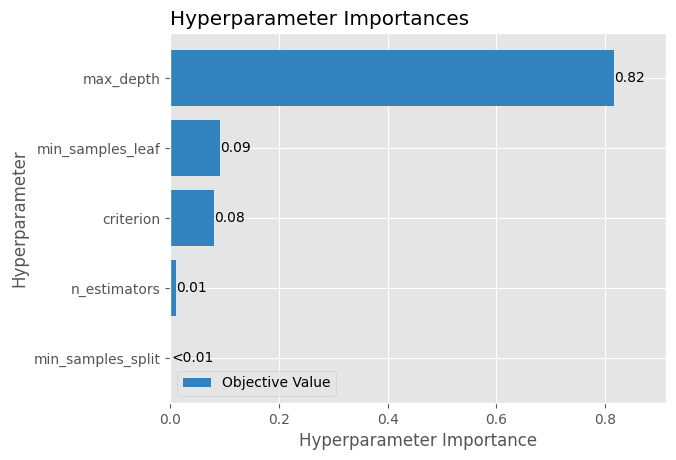

In [54]:
optuna.visualization.matplotlib.plot_param_importances(study)
plt.show()

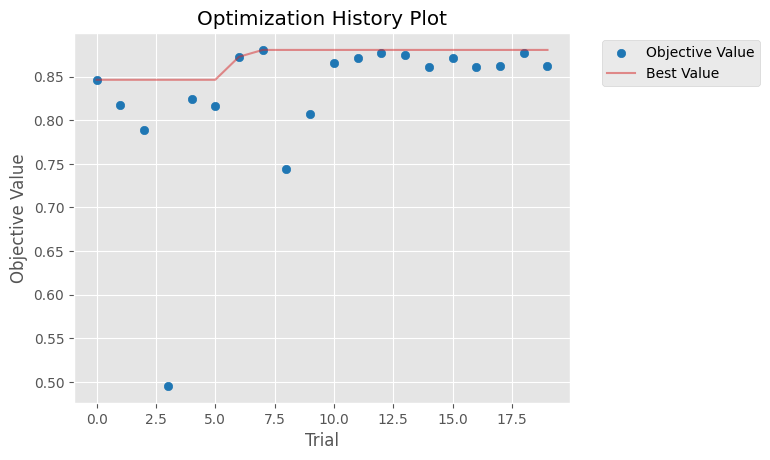

In [55]:
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.show()

Наиболее оптимальные настройки гиперпараметров.

In [56]:
ExtraTreesClassifier(**study.best_params)

ExtraTreesClassifier(criterion='entropy', max_depth=91, min_samples_leaf=2,
                     min_samples_split=3, n_estimators=123)

Обучим на тестовой выборке модель с оптимальными настройками гиперпараметров.

In [57]:
model = ExtraTreesClassifier(**study.best_params, random_state=42, n_jobs=4)

model.fit(X_resampled_train.iloc[:, 1:],y_resampled_train)
y_pred = model.predict(X_resampled_test.iloc[:, 1:])

acc = metrics.f1_score(y_resampled_test, y_pred, average='micro')

In [60]:
print(f'Точноcть предсказания на тестовой выборке: {round(acc, 4)}')

Точноcть предсказания на тестовой выборке: 0.8803


In [59]:
pd.DataFrame(metrics.classification_report(y_pred, y_resampled_test, output_dict=True)).T

,precision,recall,f1-score,support
0,0.470843,0.790436,0.590149,3994.000000
1,0.887737,0.853114,0.870082,7128.000000
2,0.990803,0.954688,0.972410,6996.000000
3,0.760883,0.870906,0.812185,5740.000000
4,0.946436,0.815111,0.875878,8259.000000
5,0.905085,0.877157,0.890902,6838.000000
6,0.507583,0.807084,0.623218,3981.000000
7,0.924565,0.880295,0.901887,7059.000000
8,0.885183,0.869527,0.877285,6898.000000
9,0.786111,0.800519,0.793250,6547.000000


Тюнинг гиперпараметров модели не оказал желаемого результата и хотя полученное значение точности достаточно высоко - попробуем примернить метод TF-IDF.

# Применим метод TF-IDF

Производим лемматизацию текста и сохраняем датафрейм для дальнейшего использования.

Так как процесс лемматизации собраннойго датасета занимает продолжительное время (около 2 часов на моих мощностях), блок лемматизации будет запущен только в первый раз. Далее будем пользоваться сохраненным датасетом с уже произведенной лемматизацией.

In [ ]:
# nlp = spacy.load("ru_core_news_lg")

# # Функция для лемматизации текста
# def make_lemmatize(text):
#     doc = nlp(text)
#     lemmatized_tokens = [token.lemma_ for token in doc]
#     return " ".join(lemmatized_tokens)

# dftfidf = dfchar[['category', 'desc_wo_stopwords']]

# tqdm.pandas()
# dftfidf['clean_text'] = dftfidf['desc_wo_stopwords'].progress_apply(lambda x : make_lemmatize(x))

# dftfidf.to_hdf('D:\scripts\diploma\output\df_with_lemmatize.h5', index=False, key='df')

Загружаем датасет с уже произведенной лемматизацией текста.

In [2]:
dftfidf = pd.read_hdf('D:\scripts\diploma\output\df_with_lemmatize.h5')
dftfidf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 246808 entries, 0 to 246807
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   category           246808 non-null  object
 1   desc_wo_stopwords  246808 non-null  object
 2   clean_text         246808 non-null  object
dtypes: object(3)
memory usage: 7.5+ MB


In [3]:
dftfidf

,category,desc_wo_stopwords,clean_text
0,Дом,"картины мотивация стену ""лев-мотиватор"" - совр...","картина мотивация стена "" лев - мотиватор "" - ..."
1,Автотовары,"колпачки колесные болты гайки , упакованы набо...","колпачок колёсный болт гайка , упаковать набор..."
2,Канцтовары,яркие декоративные стикеры наборе — прекрасный...,яркий декоративный стикер набор — прекрасный с...
3,Сад и дача,реле давления -07 предназначена автоматизации ...,реле давление -07 предназначить автоматизация ...
4,Автотовары,"камера 2,75-17 , .модель: камера 2,75-17 , 2. ...","камера 2,75 - 17 , .модель : камера 2,75 - 17 ..."
...,...,...,...
246803,Канцтовары,набор 5 конвертов бумажных пастельных оттенков...,"набор 5 конверт бумажный пастельный оттенок , ..."
246804,Канцтовары,набор плотных белых конвертов формата а3 докум...,набор плотный белый конверт формат а3 документ...
246805,Канцтовары,конверт почтовый формата с5 предназначен рассы...,конверт почтовый формат с5 предназначить рассы...
246806,Канцтовары,ожидание подарка - приятнее самого подарка! сл...,ожидание подарок - приятный самого подарок ! с...


In [4]:
# Создание объекта TfidfVectorizer
tfidf_vect = TfidfVectorizer(ngram_range=(1, 2), lowercase=False, preprocessor=None, stop_words=None)

In [5]:
# Применение TF-IDF к текстовым данным
tfidf_matrix = tfidf_vect.fit_transform(dftfidf['clean_text'])

In [6]:
tfidf_matrix

<246808x5659956 sparse matrix of type '<class 'numpy.float64'>'
	with 50183084 stored elements in Compressed Sparse Row format>

In [7]:
feature_names = tfidf_vect.get_feature_names_out()
feature_names

In [9]:
tfidf_scores = tfidf_matrix.toarray()[0]
tfidf_scores

MemoryError: Unable to allocate 10.2 TiB for an array with shape (246808, 5659956) and data type float64

УПС...слишком много данных!

Попробуем уменьшить размерность с применением TruncatedSVD.

TruncatedSVD (усеченная декомпозиция сингулярных значений) является особенно эффективным методом уменьшения размерности при обработке больших наборов данных. 

Этот метод лучше подходит для создания плотных представлений из разреженных матриц (то есть матриц со многими нулевыми элементами).

In [10]:
# Уменьшаем размерность с помощью TruncatedSVD
n_components = 200  # Указываем желаемое количество компонент
svd = TruncatedSVD(n_components=n_components)
svd_matrix = svd.fit_transform(tfidf_matrix)

# Создаем новый датафрейм с уменьшенной размерностью
df_reduced = pd.DataFrame(data=svd_matrix, columns=[f'component_{i+1}' for i in range(n_components)])

In [11]:
df_reduced

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,...,component_191,component_192,component_193,component_194,component_195,component_196,component_197,component_198,component_199,component_200
0,0.021723,0.124262,0.118981,0.142015,-0.038974,-0.128061,0.083877,0.139170,-0.082788,0.052953,...,-0.001474,-0.009943,0.009358,0.010253,-0.028882,-0.008818,-0.005677,0.006149,0.005293,-0.000417
1,0.004090,0.037348,-0.001667,0.002447,0.026999,0.004233,-0.009291,0.003457,0.001558,-0.010235,...,0.008421,0.009775,0.001441,0.002011,0.014862,-0.001510,-0.003808,0.002561,0.017476,0.006962
2,0.021966,0.099971,0.001040,0.012183,0.011866,-0.054067,0.023810,-0.018678,-0.003041,-0.011356,...,-0.008095,-0.009323,0.003382,-0.036223,-0.000667,-0.002180,-0.002954,0.010674,0.005669,-0.000916
3,0.003331,0.029781,-0.004599,0.000807,0.036233,0.015096,-0.026135,0.007893,0.006377,-0.008528,...,-0.004707,-0.015787,-0.008982,-0.011222,-0.016368,-0.005211,-0.000975,-0.020381,-0.014075,-0.016774
4,0.010705,0.063727,-0.000732,-0.004249,0.041888,0.037563,-0.002596,0.009637,-0.006705,-0.009686,...,0.006365,0.010108,0.012484,-0.010487,0.005751,0.003571,0.023263,0.006900,-0.004904,0.042435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246803,0.003927,0.034746,0.006637,-0.003063,0.001538,-0.018302,-0.001261,-0.012816,0.003837,-0.007797,...,-0.026660,0.034266,0.009840,0.021382,0.019224,0.006030,0.016522,0.041726,0.011542,0.010631
246804,0.012746,0.078710,0.023713,0.006431,0.010205,-0.023926,0.001833,0.006744,-0.012923,-0.005583,...,-0.043032,0.029789,-0.000278,0.015537,-0.003398,0.015546,0.024126,0.050380,0.013407,0.025495
246805,0.003680,0.021460,0.004176,-0.000698,0.007023,-0.012229,-0.003557,-0.009321,-0.001966,-0.010821,...,-0.035818,0.044588,-0.001422,0.025338,0.009870,0.011761,0.039904,0.065187,0.019607,0.014222
246806,0.019894,0.128814,-0.012113,0.008257,-0.015798,-0.085912,0.034153,-0.045323,0.021089,0.030576,...,-0.043019,0.046021,0.005084,0.007977,0.003939,0.005326,0.029985,0.065570,0.017575,0.022136


Добавим полученные значения в наш датафрейм

In [12]:
df_for_train = pd.concat([dftfidf, df_reduced], axis=1)

Дополним датафрейм цифровыми обозначениями категорий товаров

In [13]:
df_for_train['category_label'] = df_for_train.category.map(dict(zip(df_for_train.category.unique(), range(len(df_for_train.category.unique())))))

Убедимся в дисбалансе классов (так как загружали именно такой датасет)

In [16]:
# Функция оценки распределения данных по категориям
def value_counter(series): 
  result = pd.concat([series.value_counts(), series.value_counts(normalize=True).round(4) * 100], axis=1)
  result.columns = ['count', 'percent']
  return result

value_counter(df_for_train.category)

,count,percent
category,,
Дом,44703,18.11
Спорт,22484,9.11
Книги,18839,7.63
Сад и дача,18158,7.36
Электроника,16041,6.50
Автотовары,13772,5.58
Для ремонта,12750,5.17
Детям,12613,5.11
Женщинам,11636,4.71


Разобъем данные на фичи и целевую переменную.

In [17]:
X, y = df_for_train.drop(['category', 'desc_wo_stopwords', 'category_label'], axis=1), df_for_train.category_label

Сгенерируем синтетические данные для устранения дисбаланса классов.

In [18]:
# Создание экземпляра ADASYN
adasyn = ADASYN(sampling_strategy='auto', random_state=42, n_jobs=4)

# Применение ADASYN к данным
X_resampled, y_resampled = adasyn.fit_resample(X.iloc[:, 1:], y)

Убедимся, что дисбаланса классов больше нет.

In [19]:
df1 = pd.concat([X_resampled, y_resampled], axis=1)
value_counter(df1.category_label)

,count,percent
category_label,,
1,45917,4.46
5,45706,4.44
18,45246,4.40
12,45046,4.38
8,45028,4.38
11,45013,4.38
21,44909,4.37
4,44891,4.37
14,44879,4.36


Разобъем данные на тренировочную, валидационную и тестовую выборки. Обучим модель и посмотрим на результат.

In [20]:
X_resampled_train, X_resampled_check, y_resampled_train, y_resampled_check=train_test_split(X_resampled, y_resampled, train_size=0.7, random_state=42, stratify=y_resampled)
X_resampled_val, X_resampled_test, y_resampled_val, y_resampled_test=train_test_split(X_resampled_check, y_resampled_check,  train_size=0.5, random_state=42, stratify=y_resampled_check)

In [21]:
# Проверка размера датасетов
[i.shape[0] for i in [X_resampled, X_resampled_train, X_resampled_val, X_resampled_test]] 

[1028416, 719891, 154262, 154263]

In [22]:
# Функция оценки точности предсказания модели
def mypredictor(mymodel, Xtr, ytr, Xval, yval):
  model = mymodel
  reals = [ytr, yval]
  model.fit(Xtr, ytr)
  y_preds = model.predict(Xtr), model.predict(Xval)
  preds_acc = [round(metrics.f1_score(reals[i], y_preds[i], average='micro'), 3) for i in range(2)]
  return preds_acc

In [23]:
names = ["Extra Trees Classifier"]
models = [ExtraTreesClassifier(random_state=42, n_jobs=-1)]

In [24]:
# Цикл перебора моделей и фиксации результатов оценки качества модели
scoredict_adasyn = {}

for modname, model in enumerate(models):
  try:
    print(names[modname])
    scoredict_adasyn[names[modname]] = mypredictor(model, X_resampled_train.iloc[:, 1:], y_resampled_train, X_resampled_val.iloc[:, 1:], y_resampled_val)
  except Exception:
    print('====EXCEPTION====')
    continue

Extra Trees Classifier


In [25]:
resdf = pd.DataFrame(scoredict_adasyn, index=['train', 'val']).T.sort_values(by="val", ascending=False)

display(resdf)

,train,val
Extra Trees Classifier,0.986,0.893


Мы улучшили предыдущий результат точности модели! Посмотрим, сможем ли оттюнить модель.

In [26]:
def objective(trial):  
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 150),
        'max_depth': trial.suggest_int('max_depth', 10, 100),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 8),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 8),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'random_state': 42,
        'n_jobs': 4
    }

    model = ExtraTreesClassifier(**params)
    
    model.fit(X_resampled_train.iloc[:, 1:], y_resampled_train)
    predictions_val = model.predict(X_resampled_val.iloc[:, 1:])
    accuracy_val = metrics.f1_score(y_resampled_val, predictions_val, average='micro')

    return accuracy_val

In [27]:
study = optuna.create_study(direction='maximize', study_name="Charmodel_ExtraTreesClassifier")
study.optimize(objective, n_trials=20, gc_after_trial=True, catch=(MemoryError,))

[I 2024-05-30 04:19:17,259] A new study created in memory with name: Charmodel_ExtraTreesClassifier
[I 2024-05-30 04:20:52,161] Trial 0 finished with value: 0.8876392112120937 and parameters: {'n_estimators': 83, 'max_depth': 96, 'min_samples_leaf': 5, 'min_samples_split': 2, 'criterion': 'gini'}. Best is trial 0 with value: 0.8876392112120937.
[I 2024-05-30 04:21:53,154] Trial 1 finished with value: 0.8667721149732274 and parameters: {'n_estimators': 56, 'max_depth': 29, 'min_samples_leaf': 5, 'min_samples_split': 8, 'criterion': 'gini'}. Best is trial 0 with value: 0.8876392112120937.
[I 2024-05-30 04:24:33,220] Trial 2 finished with value: 0.8921834281935928 and parameters: {'n_estimators': 134, 'max_depth': 60, 'min_samples_leaf': 4, 'min_samples_split': 8, 'criterion': 'gini'}. Best is trial 2 with value: 0.8921834281935928.
[I 2024-05-30 04:25:17,028] Trial 3 finished with value: 0.6696334807016634 and parameters: {'n_estimators': 90, 'max_depth': 14, 'min_samples_leaf': 6, 'min_

In [28]:
print(f'Максимальное значение точноcти на валидационном наборе данных: {study.best_value}')

Максимальное значение точноcти на валидационном наборе данных: 0.8959951251766475


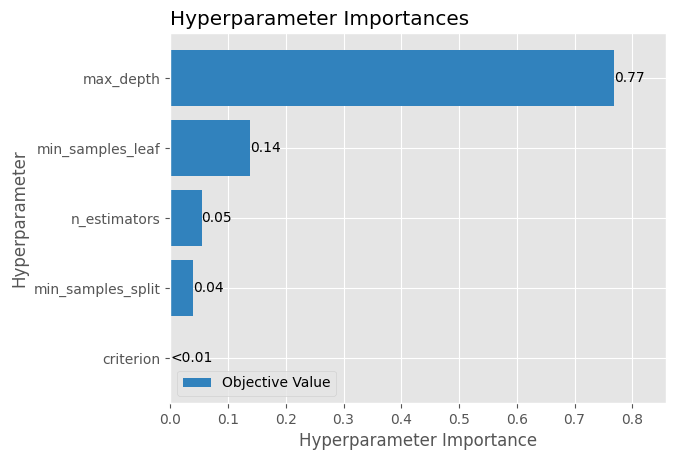

In [29]:
optuna.visualization.matplotlib.plot_param_importances(study)
plt.show()

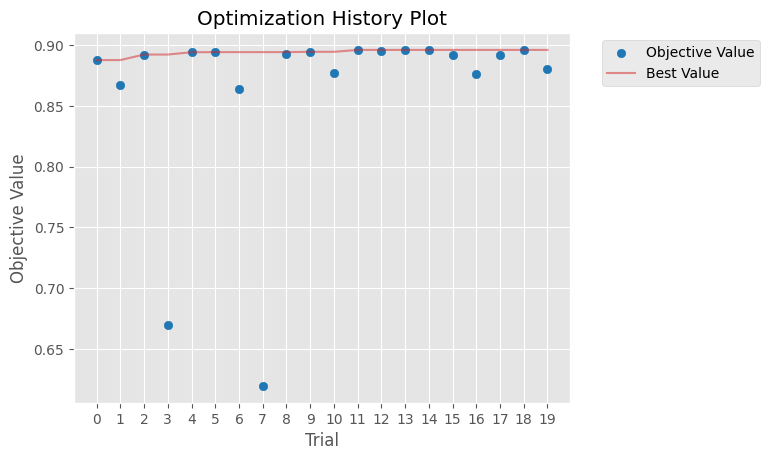

In [36]:
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.xticks(np.arange(0, 20, step=1))
plt.show()

In [31]:
ExtraTreesClassifier(**study.best_params)

ExtraTreesClassifier(max_depth=62, min_samples_leaf=2, min_samples_split=6,
                     n_estimators=109)

In [32]:
model = ExtraTreesClassifier(**study.best_params, random_state=42, n_jobs=4)

model.fit(X_resampled_train.iloc[:, 1:],y_resampled_train)
y_pred = model.predict(X_resampled_test.iloc[:, 1:])

acc = metrics.f1_score(y_resampled_test, y_pred, average='micro')

In [33]:
print(f'Точноcть предсказания на тестовой выборке: {round(acc, 3)}')

Точноcть предсказания на тестовой выборке: 0.896


In [34]:
pd.DataFrame(metrics.classification_report(y_pred, y_resampled_test, output_dict=True)).T

,precision,recall,f1-score,support
0,0.737399,0.918803,0.818167,5382.0000
1,0.915505,0.889673,0.902404,7088.0000
2,0.986978,0.949050,0.967643,6948.0000
3,0.894159,0.905343,0.899716,6476.0000
4,0.973715,0.941692,0.957436,6963.0000
5,0.894982,0.854834,0.874448,7178.0000
6,0.657277,0.851648,0.741944,5096.0000
7,0.899500,0.888722,0.894079,6677.0000
8,0.878590,0.850143,0.864133,6980.0000
9,0.748231,0.807049,0.776528,6157.0000
